# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from Utilities.model import Net
from Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary

torch.manual_seed(1)

In [4]:
CLASSES = ("Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

# Model Initialization & Summary

In [5]:
device = torch.device("mps")
model = Net(dropout_percentage=0.05, norm="bn")
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset & Dataloaders

In [6]:
from Utilities.transforms import train_transforms, test_transforms

In [7]:
from Utilities.dataset import get_dataloaders

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}
train_loader, test_loader = get_dataloaders(train_transforms=train_transforms, test_transforms=test_transforms, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Data Exploration

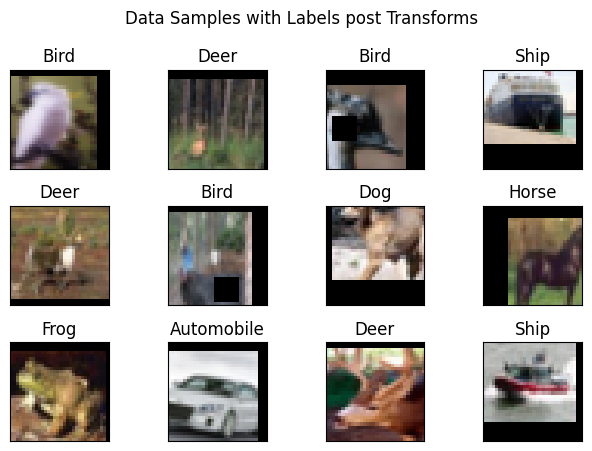

In [8]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=CLASSES)
plot_data_samples(train_loader, classes=CLASSES)

# Training

In [11]:
model = Net(dropout_percentage=0.02, norm="bn").to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
# New Line
# criterion = F.nll_loss
criterion = F.cross_entropy
num_epochs = 24

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion, train_losses, train_accs)
  test_accs, test_losses = test(model, device, test_loader, criterion, test_losses, test_accs)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1
Train: 100% Loss=1.1853 Batch_id=97 Accuracy=42.56
Test set: Average loss: 1.1787, Accuracy: 5779/10000 (57.79%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2
Train: 100% Loss=0.8508 Batch_id=97 Accuracy=64.73
Test set: Average loss: 0.8024, Accuracy: 7200/10000 (72.00%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3
Train: 100% Loss=0.6742 Batch_id=97 Accuracy=73.72
Test set: Average loss: 0.6542, Accuracy: 7723/10000 (77.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4
Train: 100% Loss=0.5460 Batch_id=97 Accuracy=78.36
Test set: Average loss: 0.7024, Accuracy: 7640/10000 (76.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5
Train: 100% Loss=0.4857 Batch_id=97 Accuracy=81.29
Test set: Average loss: 0.5731, Accuracy: 8040/10000 (80.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6
Train: 100% Loss=0.5012 Batch_id=97 Accuracy=83.35
Test set: Average loss: 0.5460,

In [52]:
import pandas as pd
bn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
bn_df.to_csv('Store/training_stats.csv', index=False)

In [53]:
import pandas as pd
bn_train = pd.read_csv("Store/training_stats.csv")
bn_train
train_accs = bn_train['Train Acc'].tolist()
test_accs = bn_train['Test Acc'].tolist()
train_losses = bn_train['Train Loss'].tolist()
test_losses = bn_train['Test Loss'].tolist()

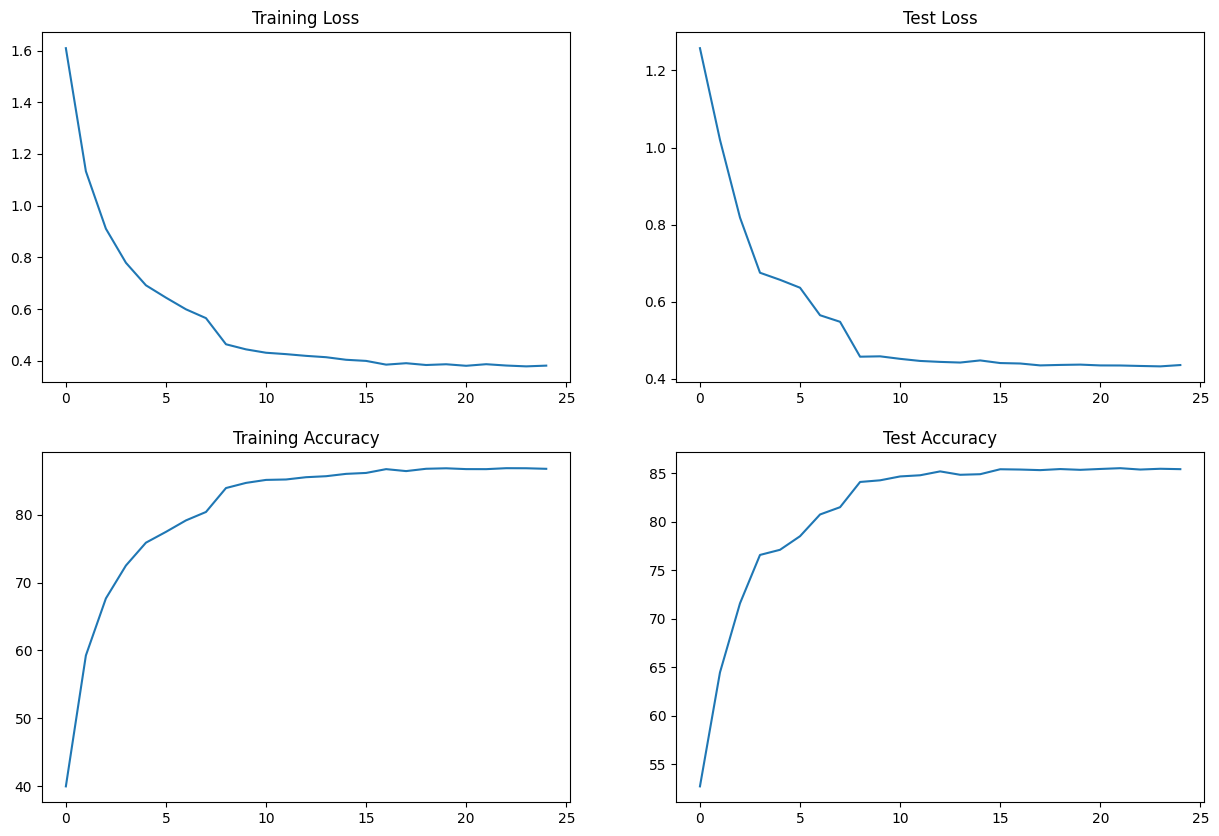

In [54]:
from Utilities.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

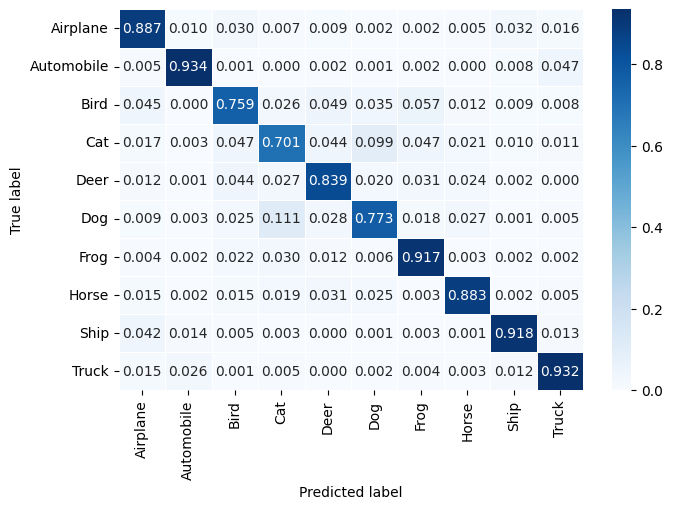

In [55]:
from Utilities.utils import get_all_and_incorrect_preds
from Utilities.visualize import plot_confusion_matrix

all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=CLASSES)

Total Incorrect Predictions 1457


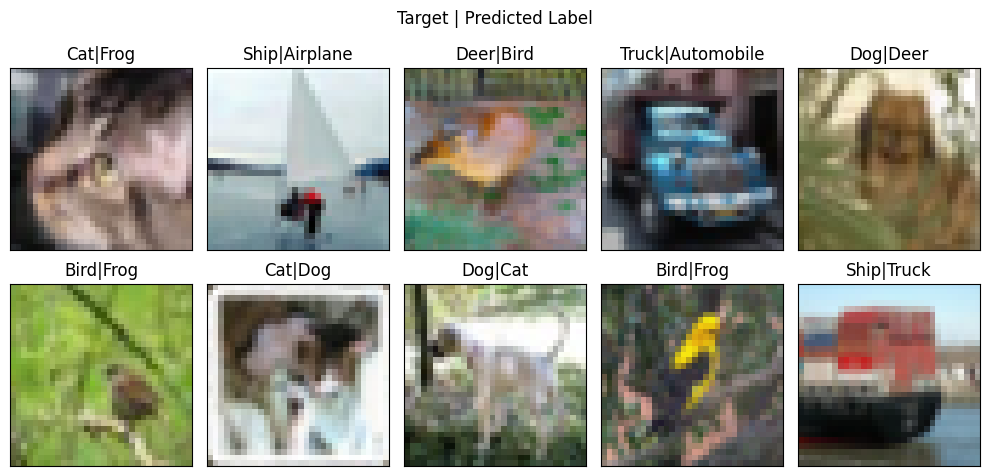

In [56]:
from Utilities.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)